In [1]:
import numpy as np
import gsd.hoomd
import multiprocessing as mp
import freud
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import sys
import os
import polychrom_hoomd.render as render

In [2]:
N = 1000
probe_dist = 360
def get_position(args):
    data, frame = args
    return data[frame].particles.position[:]

def load_conformations(gsd_file):
    with gsd_file as data:
        print('#data =', len(data))
        print(filename)

        with mp.Pool(processes=mp.cpu_count()) as pool:
            conf = pool.map(
                get_position,
                [(data, frame) for frame in range(len(data))]
                )
    return np.array(conf)
trajectories = []
directory = f'data/test_cuttoff/probedist_{probe_dist}'
for filename in os.listdir(directory):
    filename = os.path.join(directory, filename)
    gsd_file = gsd.hoomd.open(name=filename, mode='r')
    trajectories.append(load_conformations(gsd_file))
    print(filename)
# trajectories.pop(0)
trajectories = np.array(trajectories)

# Find the length of the longest trajectory
max_length = max(len(traj) for traj in trajectories)

# Number of trajectories
num_trajectories = len(trajectories)

# Initialize an array filled with NaNs
frames = np.full((num_trajectories, max_length, N, 3), 0)

# Copy each trajectory into the appropriate slice of the array
for i, traj in enumerate(trajectories):
    frames[i, :len(traj), :] = traj

gsd_file = gsd.hoomd.open(name=filename, mode='r')

L = gsd_file[0].configuration.box[0]
period = gsd_file[1].configuration.step - gsd_file[0].configuration.step
Nframes = frames.shape[-3]
dt = 0.05
time_simulation = np.linspace(0, period*Nframes*dt, Nframes)

#data = 10000
data/test_cuttoff/probedist_360/trajectory_N1000_eps10_cuttoff3.7_period1728_probedist_360_9.gsd
data/test_cuttoff/probedist_360/trajectory_N1000_eps10_cuttoff3.7_period1728_probedist_360_9.gsd
#data = 10000
data/test_cuttoff/probedist_360/trajectory_N1000_eps10_cuttoff3.7_period1728_probedist_360_23.gsd
data/test_cuttoff/probedist_360/trajectory_N1000_eps10_cuttoff3.7_period1728_probedist_360_23.gsd
#data = 10000
data/test_cuttoff/probedist_360/trajectory_N1000_eps10_cuttoff3.7_period1728_probedist_360_29.gsd
data/test_cuttoff/probedist_360/trajectory_N1000_eps10_cuttoff3.7_period1728_probedist_360_29.gsd
#data = 10000
data/test_cuttoff/probedist_360/trajectory_N1000_eps10_cuttoff3.7_period1728_probedist_360_6.gsd
data/test_cuttoff/probedist_360/trajectory_N1000_eps10_cuttoff3.7_period1728_probedist_360_6.gsd
#data = 10000
data/test_cuttoff/probedist_360/trajectory_N1000_eps10_cuttoff3.7_period1728_probedist_360_14.gsd
data/test_cuttoff/probedist_360/trajectory_N1000_eps

In [3]:
fpts = []
for traj in trajectories:
    fpts.append(len(traj))
fpts = np.array(fpts)

In [4]:
print(f'Period: {period}')
print(f'Length of trajectory: {Nframes}')
print(f'Time of simulation: {time_simulation[-1]}')

Period: 1728
Length of trajectory: 10000
Time of simulation: 864000.0


In [5]:
def compute_msd(trajectories):
    gsd_file = gsd.hoomd.open(name=filename, mode='r')
    Lx, Ly, Lz = gsd_file[0].configuration.box[0], gsd_file[0].configuration.box[1], gsd_file[0].configuration.box[2]
    box = freud.box.Box(Lx=Lx, Ly=Ly, Lz=Lz)
    msd = freud.msd.MSD(box=box, mode='window')
    print('computing MSD for')
    msd.compute(trajectories)
    return msd.msd

In [6]:
s = np.array([179, 360, 542, 363, 473, 543])
r = np.array([None, None, 0.8, 0.7, 0.73, None])
tau_auxin = np.array([None, None, 45, 27.5, 22.5, None])
tau_WT = np.array([None, None, 25.5, 18.5, 17, None])

s = np.array([542, 363, 473])
r = np.array([0.8, 0.7, 0.73])
tau_auxin = np.array([45, 27.5, 22.5])
tau_WT = np.array([25.5, 18.5, 17])

kb_scale = 1
length_scale = 66
time_scale = 260

T = frames.shape[-3]
N = frames.shape[-2]
M = frames.shape[0] 

In [7]:
#rescaling the simulation by the fitted scaling factor
b_sim = np.linalg.norm(np.diff(frames, axis =-2), axis=-1).mean(axis = 1).mean(axis = 0).mean()
print('check bond size before any transform' , b_sim)
# print(f'1 monomer represents 1kb and has size {round(((rs[1]/length_scale**2)**0.5)*1000)} nm')
frames_normalized = frames / b_sim
print('check bond size after normalizing' , np.linalg.norm(np.diff(frames_normalized, axis =-2), axis=-1).mean(axis = 1).mean(axis = 0).mean())
frames_scaled = frames_normalized/(length_scale)
b = np.linalg.norm(np.diff(frames_scaled, axis =-2), axis=-1).mean(axis = -1).mean(axis = -1)
print('check bond size (micro m) after rescaling' , b.mean())

check bond size before any transform 1.4413466502738728
check bond size after normalizing 0.999999999999899
check bond size (micro m) after rescaling 0.015151515151514805


# scale time against 1 locus MSD

In [8]:
dt_sim = time_simulation[1] - time_simulation[0]
msd = (np.linalg.norm(np.diff(frames_scaled[:, :, 0:250, :], axis = 1), axis =-1)**2).mean().mean().mean()
D = msd/(dt)
print(D)
time_scale = dt *0.01/msd
print('timescale = ', time_scale)

time  = time_simulation/ time_scale
dt = time[1] - time[0]
print(msd/(dt)) 

0.4371506003016868
timescale =  0.02287541179881439
5.786458333333334e-06


In [9]:
time_simulation = np.linspace(0, Nframes*1728/5200, Nframes)

In [37]:
dt = 0.05

[0.00000000e+00 8.64086409e-02 1.72817282e-01 ... 8.63827183e+02
 8.63913591e+02 8.64000000e+02]
computing MSD for
D 0.009914422014437933
alpha 0.5680269902293718


Text(0.5, 0, 'time (s)')

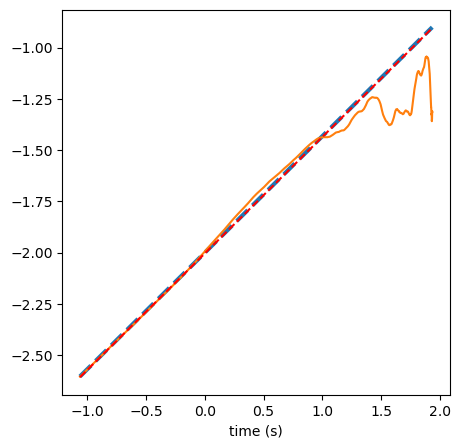

In [45]:
time_scale = 1000
# time = np.linspace(0, period*Nframes*dt, Nframes)
print(time)

traj = frames_scaled[6,:1000,100:250,:]
y = np.log10(compute_msd(traj[:])[1:])
x = np.log10(time[:1000][1:]/time_scale)
x = np.log10(time[:1000][1:])

# linear fit in loglog space
def func(x, a, b):
    return a*x + b
p,q = 0, 10
popt, pcov = curve_fit(func, x[p:q], y[p:q])
print('D', np.power(10, popt[1]))
print('alpha', popt[0])

plt.figure(figsize=(5,5))
plt.plot(x, popt[0]*x + np.log10(0.01), '--', label = f'experimental MSD -> D=0.01 mu^2/s', linewidth = 3)
plt.plot(x, y)
plt.plot(x, func(x, *popt), 'r--')
plt.xlabel('time (s)') 

In [25]:
print('dt =', dt, 's', 'total time =', round(time[-1]/60), 'min |',  round(time[-1]/3600), 'hours')

dt = 3777.3589224988236 s total time = 55 min | 1 hours


In [44]:
time = np.linspace(0, period*Nframes*dt, Nframes)
time = time/time_scale

# two locus  MSD

In [41]:
print('r = ', r,' s = ', s,' FPT auxin = ', tau_auxin)
cuttoff = 3.7/length_scale
print('cuttof =',  round(3.7/length_scale*1000), 'nm')

r =  [0.8  0.7  0.73]  s =  [542 363 473]  FPT auxin =  [45.  27.5 22.5]
cuttof = 56 nm


In [59]:
np.linalg.norm(frames_scaled[:,:,probe_position_1+10,:] - frames_scaled[:,:,probe_position_1,:], axis = -1).std(axis = -1).mean()

0.057729806919144804

In [46]:
k = 400
N = frames.shape[1]

probe_position_1 = 300
probe_position_2 = 300 + probe_dist
separation = probe_position_2 - probe_position_1
# rij = np.array([(frames_scaled[:,i,:] - frames_scaled[:,i+k,:]) for i in np.linspace(k,N-k-1, (np.floor(N/k)).astype(int)).astype(int)])
rij = np.array([frames_scaled[:,:,probe_position_1,:] - frames_scaled[:,:,probe_position_2,:]]) 
print(rij.shape, k)
rij = np.swapaxes(np.array(rij), 0,1)
rij_k = (np.linalg.norm(rij, axis = -1)).mean(axis=1).mean()
# MSD_two_k = compute_msd(rij)

(1, 31, 10000, 3) 400


In [49]:
time = np.linspace(0, (Nframes*period/5200)*2, Nframes)

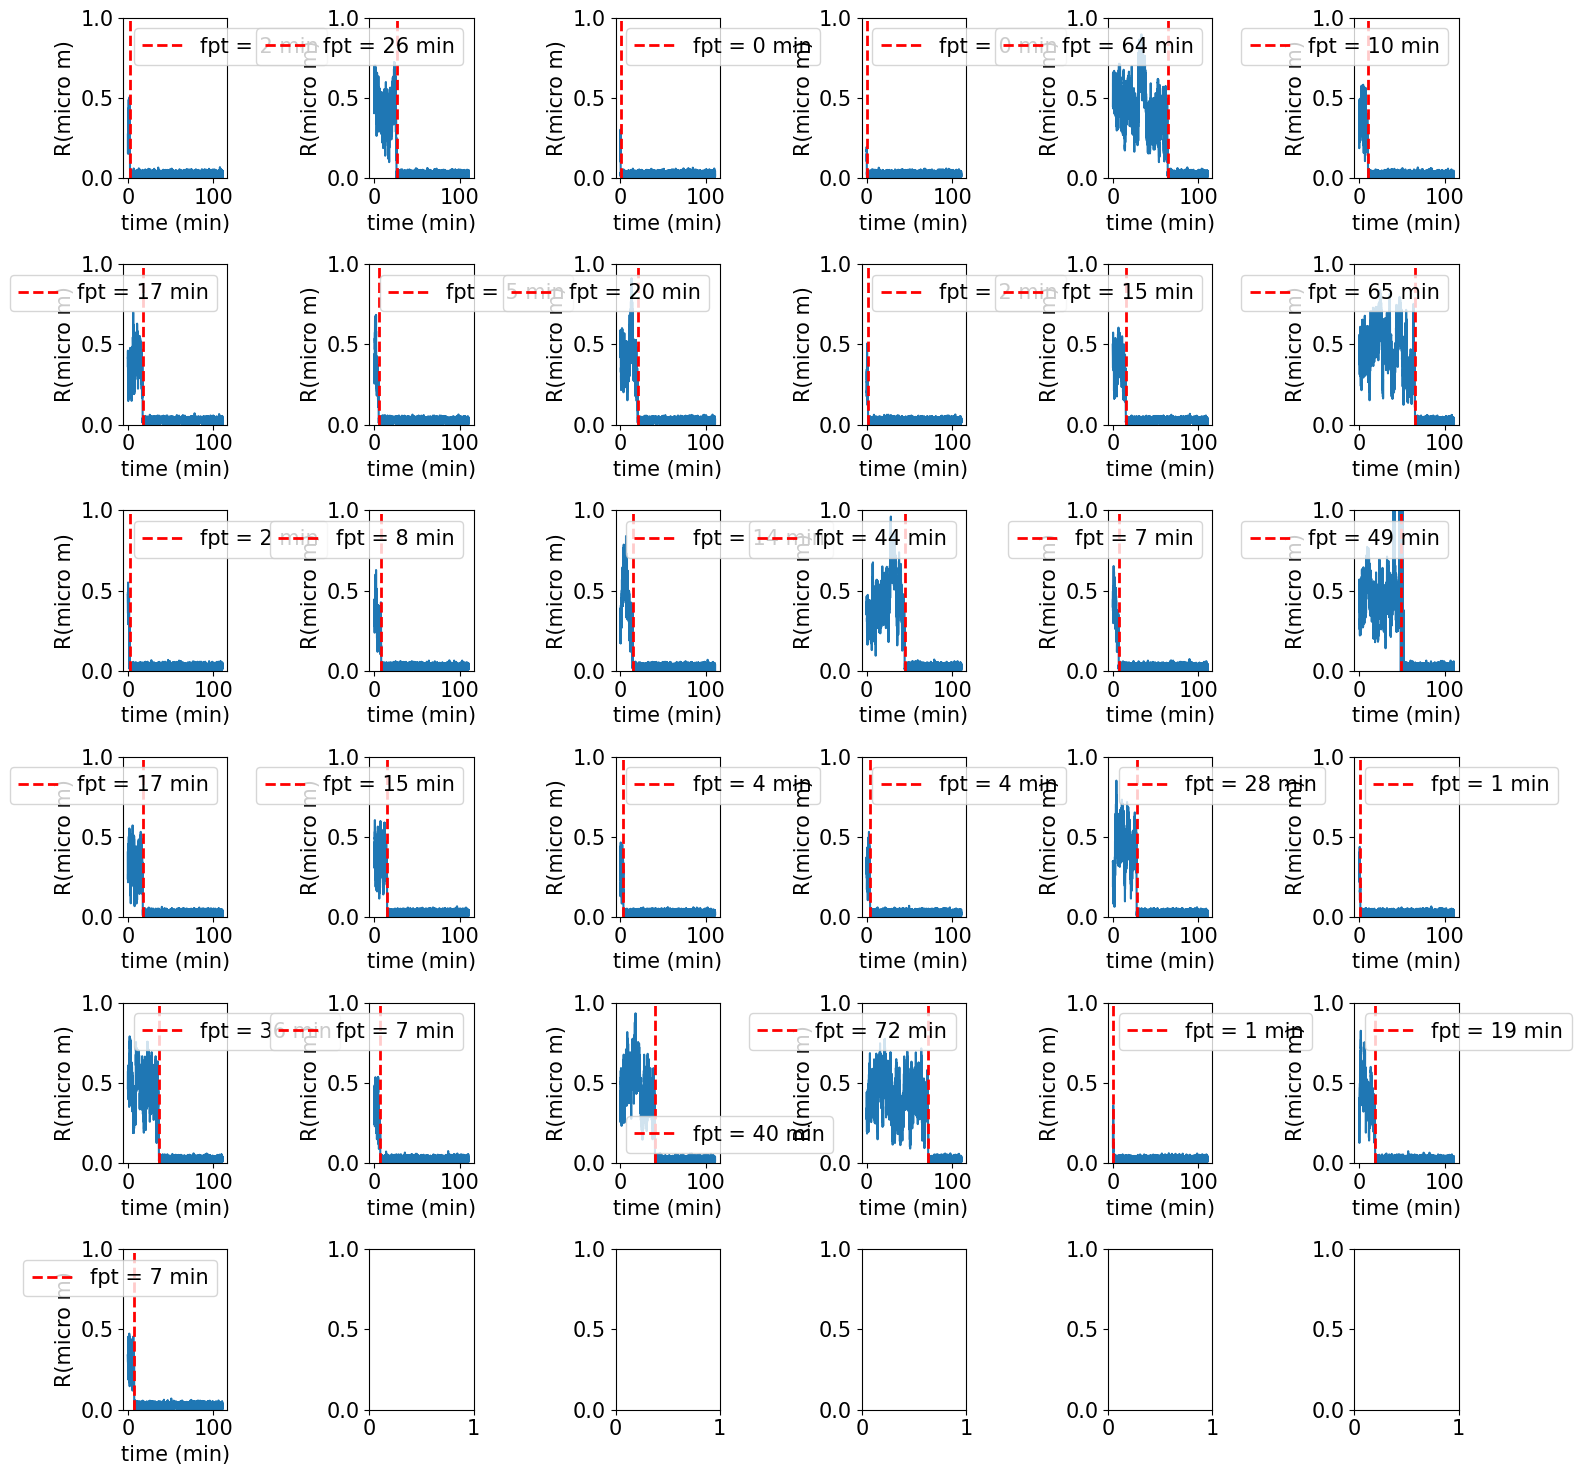

In [70]:
target_sizes = np.linspace(0.08, 0.5, 100)

SMALL_SIZE = 15
MEDIUM_SIZE = 15
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

k = 16
target_size = 0.015
fpts = []
kmax = len(frames)
# kmax = 
ncols = int(np.ceil(np.sqrt(kmax)))
nrows = int(np.ceil(kmax / ncols))
# nrows = 2


fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
# Flatten axes array for easy indexing
w1, w2 = 0, -1
axes = axes.flatten()
for k in range(kmax):
    norm_rij = np.linalg.norm(rij[:,0,:], axis = -1)
    x = time[w1:w2]/60
    y = norm_rij[k][w1:w2]
    y[y>1.8] = 0
    axes[k].plot(x, y)
    cmap = plt.get_cmap('viridis')
    # for target_size in target_sizes[::10]:
    #     plt.axhline(target_size, color = cmap(target_size/max(target_sizes)))
    # plt.axhline(target_size, color = cmap(target_size/max(target_sizes)), label = 'target size')
    fpt = time[np.argmax(norm_rij[k] < target_size)]
    fpts.append(fpt)
    axes[k].axvline(fpt/60, label = f'fpt = {round(fpt/60)} min', color = 'r', linestyle = '--', linewidth = 2)
    axes[k].set_xlabel('time (min)')
    axes[k].set_ylabel('R(micro m)')
    axes[k].legend()
    axes[k].set_ylim(0, 1)
plt.tight_layout()
fpts = np.array(fpts)

fpt =  19.562373110760213 min


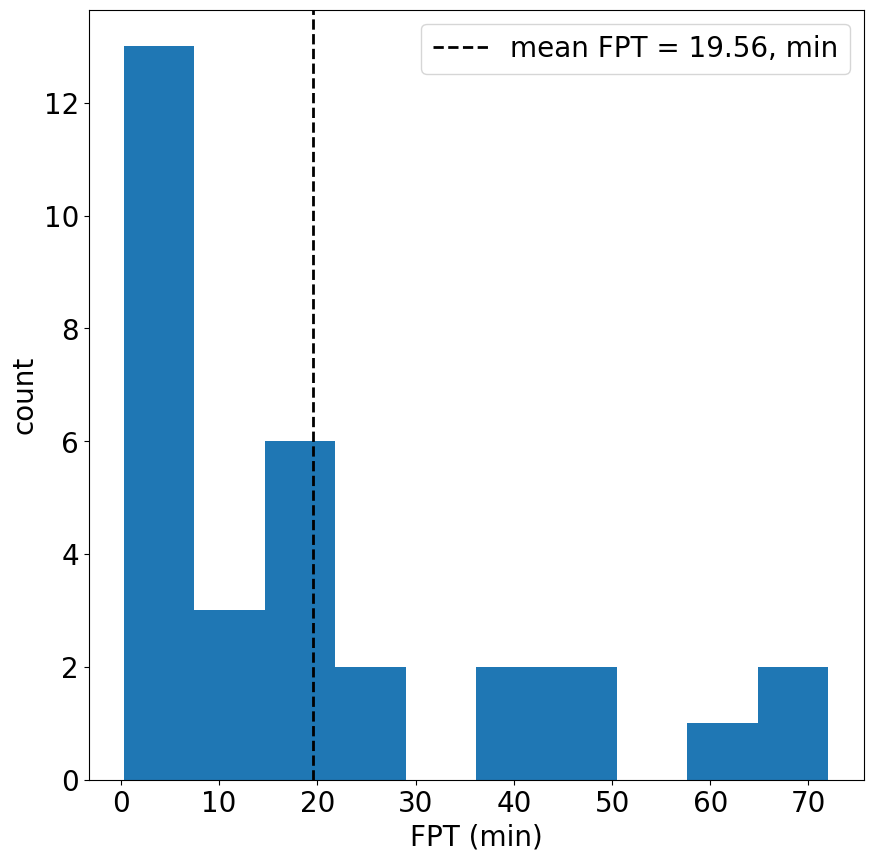

In [71]:
SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(10,10))
plt.hist(fpts/60)
print('fpt = ', fpts.mean()/60 , 'min')
plt.xlabel('FPT (min)')
plt.ylabel('count')
plt.axvline(fpts.mean()/60, color = 'k', linestyle = '--', linewidth = 2, label = f'mean FPT = {round(fpts.mean()/60, 2)}, min')
plt.legend()

tau =  18 min


/tmp/ipykernel_24236/2125783695.py:9: RuntimeWarning: invalid value encountered in log10
  y = np.log10(MSD_two_k)[1:]
/tmp/ipykernel_24236/2125783695.py:10: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(np.arange(len(y)+1))[1:]


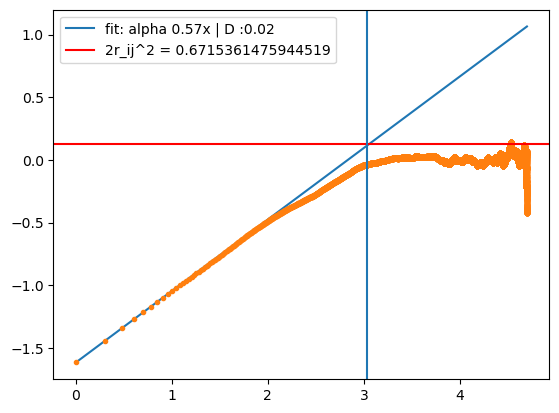

In [341]:

from scipy.special import erfc

def M2(t, gamma2, tau, J):
    term1 = 2 * gamma2 * np.sqrt(t) * (1 - np.exp(-tau / (np.pi * t)))
    term2 = 2 * J * erfc(np.sqrt(tau / (np.pi * t)))
    return term1 + term2


y = np.log10(MSD_two_k)[1:]
x = np.log10(np.arange(len(y)+1))[1:]

p,q = 0, 10

param, pcov = np.polyfit(x[p:q], y[p:q], 1, cov=True)
D = np.power(10,param[1])
alpha = param[0]
plt.plot(x, param[0]*x + param[1], label = f'fit: alpha {alpha:.2f}x | D :{D:.2f}')

# p,q = 0, 100
# param, pcov = curve_fit(M2, np.exp(x)[p:q], np.exp(y)[p:q], p0=[1, 200, 1])
# # plt.plot(x, np.log10(M2(np.exp(x), *param)), label = f'fit: D: {param[0]:.2f} | tau: {param[1]:.2f} | rij^2: {param[2]:.2f}')
tau = (rij_k/D)**2.1
plt.plot(x,y, '.')
plt.axhline(np.log10(rij_k*2), color='r', label=f'2r_ij^2 = {rij_k}')
plt.axvline(np.log10(tau))

print('tau = ', round(tau/60), 'min')

plt.legend()



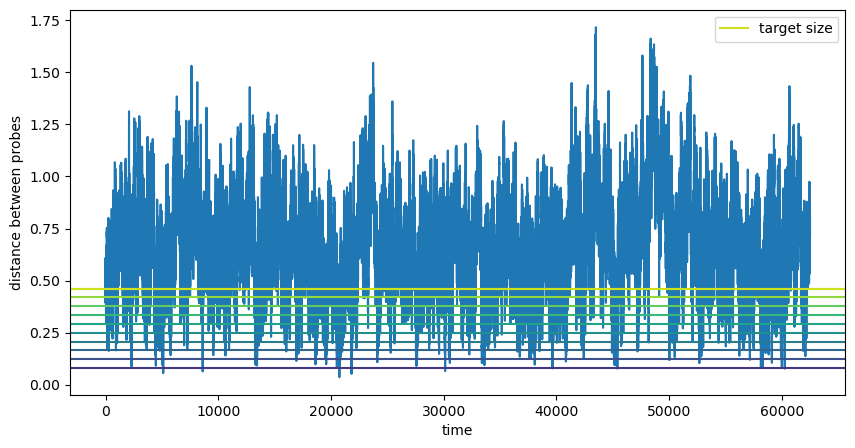

In [348]:
# plot the target sizes and the distance between the two probes over time with a color map for the target sizes
target_sizes = np.linspace(0.08, 0.5, 100)
plt.figure(figsize=(10,5))


norm_rij = np.linalg.norm(rij[:,0,:], axis = -1)
w1, w2 = 0, -1
plt.plot(time[w1:w2], norm_rij[w1:w2])
cmap = plt.get_cmap('viridis')
for target_size in target_sizes[::10]:
    plt.axhline(target_size, color = cmap(target_size/max(target_sizes)))
plt.axhline(target_size, color = cmap(target_size/max(target_sizes)), label = 'target size')
plt.xlabel('time')
plt.ylabel('distance between probes')
plt.legend()
plt.show()

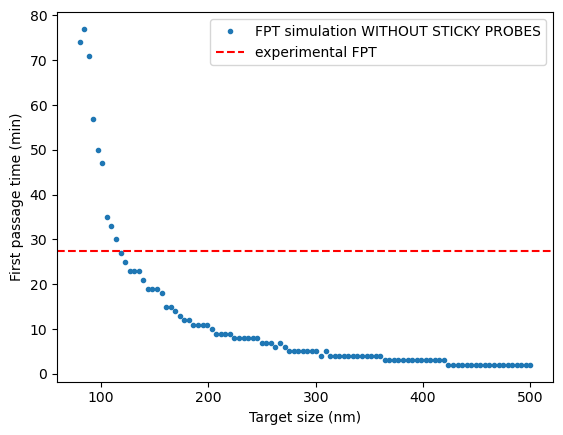

In [349]:
fpts_means = []
for target_size in target_sizes:
    fpts = []
    for k in range(2000):
        t = np.random.randint(0, 49_000)
        rij_conditionned = norm_rij[t:]
        if norm_rij[t]>target_size:
            fpts.append(np.argmax(rij_conditionned < target_size))
    fpts_means.append(np.mean(fpts)/time_scale)
fpts_means = np.array(fpts_means) 

# fit a power law to the data
def power_law(x, a, b, c):
    return a*x**b + c

x = target_sizes*1000
y = np.round(fpts_means/60)

# popt, pcov = curve_fit(power_law, x, y, p0=[1, -2, 1])
# plt.plot(x, power_law(x, *popt), label=f'fit: {popt[0]:.4f}x^{popt[1]:.2f} + {popt[2]:.2f}')
plt.ylabel('First passage time (min)')
plt.xlabel('Target size (nm)')
plt.plot(x, y, '.', label='FPT simulation WITHOUT STICKY PROBES')
plt.axhline(27.5, color='r', linestyle='--', label='experimental FPT')
plt.legend()

In [354]:
(30*60/dt)*(300_000_000/50_000)

8640000.0

In [356]:
rs[10]

23.815607286502477

In [358]:
0.06/b

3.6835622642545083

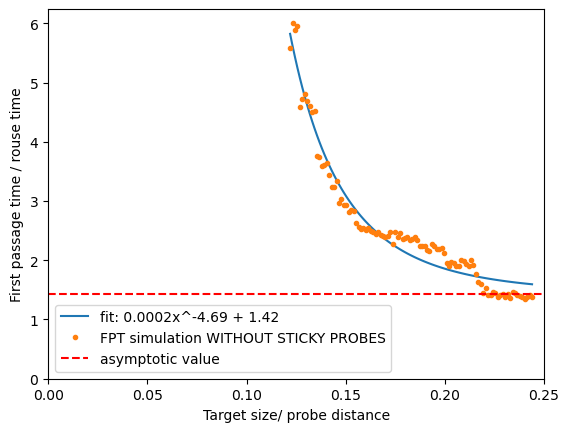

In [330]:
fpts_means = []
for target_size in target_sizes:
    fpts = []
    for k in range(2000):
        t = np.random.randint(0, 49_000)
        rij_conditionned = norm_rij[t:]
        if norm_rij[t]>target_size:
            fpts.append(np.argmax(rij_conditionned < target_size))
    fpts_means.append(np.mean(fpts)/time_scale)
fpts_means = np.array(fpts_means) 

# fit a power law to the data
def power_law(x, a, b, c):
    return a*x**b + c

x = (target_sizes)/(rij_k**0.5)

#/np.sqrt(separation)
y = (fpts_means/tau)

popt, pcov = curve_fit(power_law, x, y, p0=[1, -2, 1])
plt.plot(x, power_law(x, *popt), label=f'fit: {popt[0]:.4f}x^{popt[1]:.2f} + {popt[2]:.2f}')
plt.ylabel('First passage time / rouse time')
plt.xlabel('Target size/ probe distance')
plt.plot(x, y, '.', label='FPT simulation WITHOUT STICKY PROBES')
plt.axhline(popt[2], color='r', linestyle='--', label='asymptotic value')
plt.ylim(0)
plt.xlim(0)

plt.legend()

In [276]:
popt[0]

0.00031378669767597795

In [260]:
tau_auxin


array([45. , 27.5, 22.5])